### This Notebook Evaluates Replicate Out Cross-Validation to Better Measure how the model generalises

Group KFold Cross-Validation prevents spectra from the same Surface appearing within both the training and test folds.

This gives a better indication of the model's ability to generalise, as it stops leakage between samples from the same fold.

Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.model_selection import LeavePGroupsOut

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [4]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [5]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [6]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [7]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239205 entries, 293 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 333.2+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [9]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [10]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [11]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal


>**Count the Surface IDs and the number of associated samples**

In [14]:
len(df['SurID'].unique())

63

In [11]:
# Count unique combinations
unique_combos_count = wavelength_df.groupby(['SurID', 'Status']).size().reset_index(name='Count of Spectra per Surface')
unique_combos_count

,SurID,Status,Counts
0,201210-1,Normal,49
1,201210-2,Normal,50
2,210114-1,Normal,50
3,210114-2,Normal,50
4,210120-1,Hyperglycemia,50
...,...,...,...
58,210519-3,Hyperglycemia,50
59,210524-1,Hypoglycemia,15
60,210526-1,Hyperglycemia,50
61,210526-2,Hyperglycemia,15


>#### **Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with GroupKFold cross-validation.**

Leaves out certain SurIDs out to evaluate the models ability to generalise.

In [12]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [13]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5350 +/- 0.1277


>Scale the absorbances to the highest peak in each spectrum.

In [14]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [15]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755


In [16]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [17]:
scaled_raw_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.953424,0.958347,0.955242,0.948434,0.949755,0.952110,0.942389,0.957576,0.958312,0.946763,...,0.653646,0.655516,0.661592,0.653377,0.653747,0.644989,0.645355,0.642506,201210-1,Normal
201210-1-01,0.966924,0.964678,0.960813,0.960696,0.965006,0.970900,0.972982,0.965186,0.967645,0.965453,...,0.679699,0.670361,0.668847,0.665616,0.665119,0.665591,0.669153,0.673599,201210-1,Normal
201210-1-02,0.590483,0.581552,0.580569,0.584174,0.586323,0.584617,0.580471,0.577371,0.579706,0.578570,...,0.534629,0.538094,0.540060,0.535479,0.534627,0.539708,0.534086,0.533271,201210-1,Normal
201210-1-03,0.708234,0.704009,0.701777,0.705123,0.711097,0.713373,0.711019,0.714794,0.709518,0.701358,...,0.577106,0.585868,0.579843,0.582236,0.581193,0.584320,0.590369,0.579500,201210-1,Normal
201210-1-04,0.915371,0.914627,0.913193,0.912225,0.909200,0.906628,0.909496,0.906893,0.905394,0.899338,...,0.817176,0.794517,0.798681,0.799072,0.801119,0.808060,0.801357,0.816381,201210-1,Normal


In [18]:
#scaled_raw_df.to_csv("../../data/scaled_raw_spectra.csv")

In [19]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4987 +/- 0.0945


> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [20]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [21]:
df  

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,1765.6628
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,1774.7809
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,1769.0302
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,1756.4220
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,1758.8690
...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079,1617.3926
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651,1633.0911
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742,1633.3076
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325,1641.8665


In [22]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [23]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5419 +/- 0.1319


Despike with scaling.

In [24]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [25]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [26]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5016 +/- 0.0977


This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [27]:
# def baseline_als_optimized(y, lam, p, niter=10):
#     L = len(y)
#     D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
#     D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
#     w = np.ones(L)
#     W = sparse.spdiags(w, 0, L, L)
#     for i in range(niter):
#         W.setdiag(w) # Do not create a new matrix, just update diagonal values
#         Z = W + D
#         z = spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

In [28]:
from pybaselines.whittaker import asls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        return corrected

The PyBaselines Library Performs this much faster.

Here is an example on 1 spectrum

In [29]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8013328,210526-3-06,293,400.22778,2367.7305,210526-3,Hyperglycemia,0.832666,2367.7305,0.832666
8013329,210526-3-06,294,400.91116,2352.8223,210526-3,Hyperglycemia,0.827424,2352.8223,0.827424
8013330,210526-3-06,295,401.59454,2377.9473,210526-3,Hyperglycemia,0.836259,2377.9473,0.836259
8013331,210526-3-06,296,402.27789,2394.0313,210526-3,Hyperglycemia,0.841916,2394.0313,0.841916
8013332,210526-3-06,297,402.96127,2376.4995,210526-3,Hyperglycemia,0.835750,2376.4995,0.835750
...,...,...,...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia,0.691909,1967.4805,0.691909
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia,0.691066,1965.0815,0.691066
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia,0.684900,1947.5498,0.684900
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia,0.686425,1951.8849,0.686425


/tmp/ipykernel_64420/612811503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

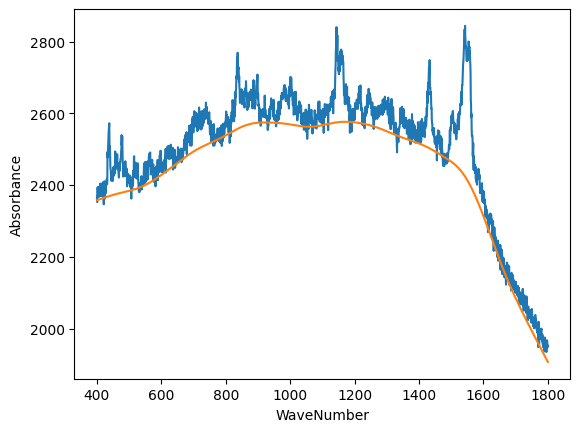

In [30]:
lam = 10 ** 6
p = 0.01

# lam = 10 ** 7
# p = 0.05

# lam = 10 ** 9
# p = 0.1
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_64420/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

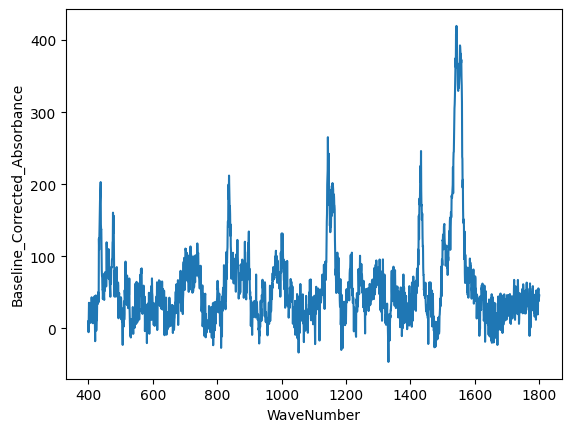

In [31]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_64420/2008908675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

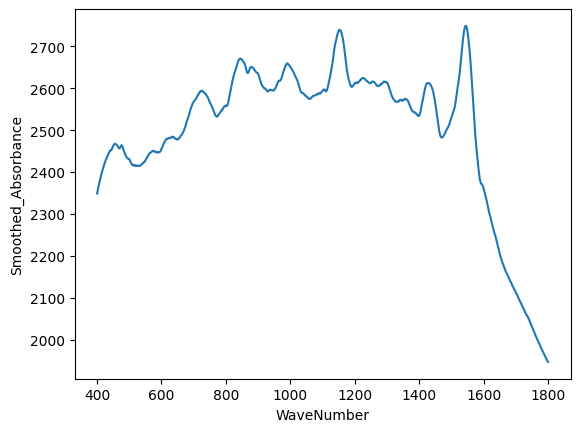

In [32]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_64420/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

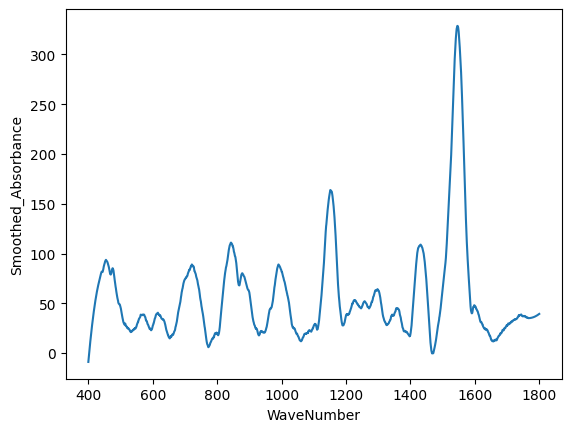

In [33]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

/tmp/ipykernel_64420/1280720429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

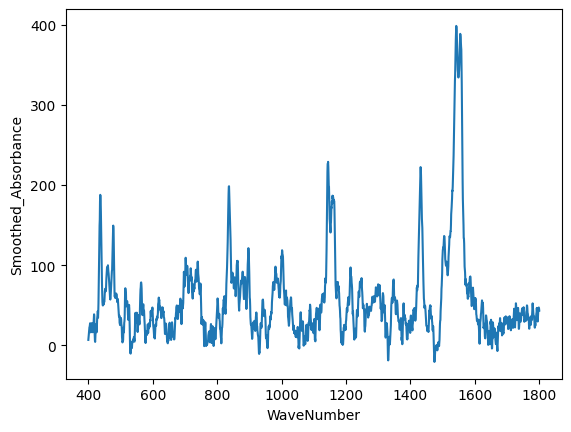

In [34]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [35]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [36]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance,Baseline_Corrected_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,1765.6628,0.953424,24.824567
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,1774.7809,0.958347,34.279384
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,1769.0302,0.955242,28.865400
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,1756.4220,0.948434,16.593916
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,1758.8690,0.949755,19.377630


In [37]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [38]:
baseline_corrected_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,24.824567,34.279384,28.865400,16.593916,19.377630,24.075342,6.410549,34.872151,36.572046,15.520232,...,27.948138,32.037429,43.917517,29.329902,30.641385,15.050168,16.354050,11.703932,201210-1,Normal
201210-1-01,11.747590,7.634711,0.229032,0.446653,9.671974,22.117393,26.809312,11.405629,16.864644,12.862355,...,56.844358,38.551058,36.175250,30.305537,29.999519,31.662798,39.611177,49.359554,201210-1,Normal
201210-1-02,45.767700,13.415231,10.441862,24.425492,33.031020,27.386545,12.718366,1.921682,11.211991,7.672991,...,29.115236,42.687530,50.714017,34.541898,32.152376,51.697052,31.677128,29.423102,201210-1,Normal
201210-1-03,23.043036,9.254346,2.347456,14.695766,36.120174,44.772381,37.446286,51.276187,33.857083,6.486072,...,10.683979,42.229530,22.721673,32.279309,29.972142,42.062071,64.237000,28.008728,201210-1,Normal
201210-1-04,48.503421,47.132020,44.065619,42.143216,35.164911,29.301801,36.811484,30.869758,27.642419,13.213866,...,60.365182,5.805818,17.194146,19.303067,25.485384,43.697397,28.368009,66.453221,201210-1,Normal


In [39]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5639 +/- 0.1272


Scale the Baseline Corrected Absorbances to the highest peak.

In [40]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [41]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [42]:
evaluate_extra_trees(scaled_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5178 +/- 0.1195


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [43]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [44]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [45]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5347 +/- 0.1218


In [46]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [47]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [48]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4915 +/- 0.0948


In [49]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [50]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [51]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5278 +/- 0.1290


In [52]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [53]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [54]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4832 +/- 0.0932


Try this on the baseline corrected spectra.

In [55]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [56]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [57]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5836 +/- 0.1273


In [58]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [59]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [60]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5250 +/- 0.1146


In [61]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [62]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [63]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5826 +/- 0.1257


In [64]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [65]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [66]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5186 +/- 0.0836


This is worse, lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [67]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [68]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [69]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [70]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5545 +/- 0.0882


----

The negative impact of scaling the unsmoothed baseline is strange.

In [71]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [72]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [73]:
evaluate_extra_trees(no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5708 +/- 0.1332


Then with scaling.

In [74]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [75]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [76]:
scaled_no_negative.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.128976,0.178098,0.149970,0.086213,0.100676,0.125083,0.033306,0.181178,0.190010,0.080635,...,0.145204,0.166450,0.228173,0.152383,0.159197,0.078193,0.084967,0.060808,201210-1,Normal
201210-1-01,0.058575,0.038068,0.001142,0.002227,0.048226,0.110281,0.133676,0.056870,0.084090,0.064134,...,0.283435,0.192222,0.180376,0.151108,0.149583,0.157876,0.197508,0.246115,201210-1,Normal
201210-1-02,0.029793,0.008733,0.006797,0.015900,0.021502,0.017828,0.008279,0.001251,0.007299,0.004995,...,0.018953,0.027788,0.033013,0.022485,0.020930,0.033653,0.020621,0.019153,201210-1,Normal
201210-1-03,0.021311,0.008559,0.002171,0.013591,0.033405,0.041407,0.034632,0.047422,0.031312,0.005999,...,0.009881,0.039055,0.021014,0.029853,0.027719,0.038901,0.059409,0.025904,201210-1,Normal
201210-1-04,0.200447,0.194779,0.182107,0.174163,0.145324,0.121094,0.152128,0.127573,0.114236,0.054608,...,0.249467,0.023993,0.071057,0.079773,0.105322,0.180585,0.117235,0.274627,201210-1,Normal


In [77]:
evaluate_extra_trees(scaled_no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5133 +/- 0.1089


Try Min-Max Scaling Instead

In [78]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [79]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [80]:
evaluate_extra_trees(min_max_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5100 +/- 0.1042


In [81]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [82]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [83]:
min_max_baseline_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.262185,0.303795,0.279969,0.225963,0.238214,0.258888,0.181147,0.306404,0.313885,0.221238,...,0.275932,0.293929,0.346212,0.282013,0.287785,0.219169,0.224907,0.204442,201210-1,Normal
201210-1-01,0.178989,0.161104,0.128901,0.129848,0.169963,0.224081,0.244483,0.177502,0.201240,0.183836,...,0.375088,0.295541,0.285210,0.259686,0.258355,0.265588,0.300151,0.342541,201210-1,Normal
201210-1-02,0.052032,0.031454,0.029563,0.038457,0.043931,0.040341,0.031011,0.024144,0.030053,0.027802,...,0.041440,0.050073,0.055178,0.044892,0.043372,0.055803,0.043070,0.041636,201210-1,Normal
201210-1-03,0.072124,0.060034,0.053978,0.064805,0.083590,0.091177,0.084753,0.096879,0.081606,0.057606,...,0.061287,0.088947,0.071842,0.080222,0.078199,0.088800,0.108244,0.076478,201210-1,Normal
201210-1-04,0.290296,0.285265,0.274017,0.266965,0.241367,0.219860,0.247407,0.225611,0.213773,0.160845,...,0.333807,0.133671,0.175446,0.183182,0.205860,0.272666,0.216434,0.356140,201210-1,Normal


In [84]:
evaluate_extra_trees(min_max_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5111 +/- 0.1221


In [85]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [86]:
evaluate_extra_trees(vector_scale_raw)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5349 +/- 0.0906


Try on the baseline corrected spectra.

In [87]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [88]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [89]:
evaluate_extra_trees(vector_scale_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5361 +/- 0.1233
